In [1]:
# Run once in the notebook environment
!pip install -q transformers torch torchvision captum shap torchvision matplotlib opencv-python-headless scikit-learn

In [1]:
import os
from pathlib import Path
import json
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModel

import torchvision
from torchvision import transforms, models

import shap
from captum.attr import IntegratedGradients, LayerGradCam, LayerAttribution

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

# Paths - ADAPT HERE if your files are elsewhere
ROOT = Path(".")
CSV_PATH = ROOT / "fake_job_postings.csv"
IMAGES_DIR = ROOT / "images"   # expects images/0/<job_id>.png and images/1/<job_id>.png
OUT_DIR = ROOT / "xai_outputs"
OUT_DIR.mkdir(exist_ok=True)

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# Hyperparams - adjust for speed / quality
MODEL_NAME = "distilbert-base-uncased"   # text encoder
IMG_INPUT_SIZE = 224
BATCH_SIZE = 8        # ADAPT: increase if GPU available
NUM_EPOCHS = 3        # small quick training; increase for production
LR = 2e-5
SHAP_TEXT_EVALS = 150  # increase for better fidelity
SHAP_IMAGE_EVALS = 150
SHAP_META_NSAMPLES = 200

/opt/homebrew/Caskroom/miniconda/base/envs/cse572/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cpu


In [2]:
assert CSV_PATH.exists(), f"CSV not found at {CSV_PATH}"

df = pd.read_csv(CSV_PATH, dtype=str)
df['job_id'] = df['job_id'].astype(str)
df['fraudulent'] = df['fraudulent'].fillna("0").astype(int)

# Combined text column
def join_text(row):
    parts = []
    for c in ("title","company_profile","description","requirements","benefits"):
        if c in row and pd.notna(row[c]):
            parts.append(str(row[c]))
    return "\n\n".join(parts)
df['text'] = df.apply(join_text, axis=1)

# Simple metadata features (numerical/categorical -> simple numeric flags)
df['has_company_logo'] = df.get('has_company_logo', "0").fillna("0").astype(int)
df['has_questions'] = df.get('has_questions', "0").fillna("0").astype(int)
df['telecommuting'] = df.get('telecommuting', "0").fillna("0").astype(int)
df['has_salary'] = (~df.get('salary_range', pd.Series([""]*len(df))).isna()) & (df.get('salary_range', pd.Series([""]*len(df))).str.strip()!="")
df['has_salary'] = df['has_salary'].astype(int)

meta_feature_names = ['has_company_logo','has_questions','telecommuting','has_salary']

# Map image paths
def find_image(job_id, lab):
    for ext in (".png", ".jpg", ".jpeg"):
        p = IMAGES_DIR / str(lab) / f"{job_id}{ext}"
        if p.exists():
            return str(p)
    # fallback
    if IMAGES_DIR.exists():
        for sub in IMAGES_DIR.iterdir():
            if not sub.is_dir(): continue
            for ext in (".png", ".jpg", ".jpeg"):
                p = sub / f"{job_id}{ext}"
                if p.exists(): return str(p)
    return ""

df['image_path'] = df.apply(lambda r: find_image(r['job_id'], r['fraudulent']), axis=1)
print("Rows:", len(df), "Missing images:", (df['image_path']=="").sum())
df.head(2)

Rows: 17880 Missing images: 84


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,...,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,text,has_salary,image_path
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,...,0,Other,Internship,NaN,NaN,Marketing,0,"Marketing Intern\n\nWe're Food52, and we've cr...",0,images/0/1.png
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,...,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,Customer Service - Cloud Video Production\n\n9...,0,images/0/2.png


In [3]:
trainval, test = train_test_split(df, test_size=0.15, stratify=df['fraudulent'], random_state=42)
train, val = train_test_split(trainval, test_size=0.1765, stratify=trainval['fraudulent'], random_state=42)  # approx 70/15/15
print("Sizes (train/val/test):", len(train), len(val), len(test))

Sizes (train/val/test): 12515 2683 2682


In [4]:
# Text tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Image preprocessing (should match image backbone expectations)
image_preprocess = transforms.Compose([
    transforms.ToPILImage() if isinstance(np.zeros(1), np.ndarray) else transforms.Lambda(lambda x: x),
    transforms.Resize((IMG_INPUT_SIZE, IMG_INPUT_SIZE)),
    transforms.ToTensor(),   # C,H,W float in [0,1]
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# A simpler preprocess function that accepts numpy HWC image and returns tensor C,H,W
def preprocess_image_np(img_np):
    return image_preprocess(img_np)

In [5]:
class MultimodalJobDataset(Dataset):
    def __init__(self, df, tokenizer, meta_cols, image_dir, img_transform, max_length=128):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.meta_cols = meta_cols
        self.image_dir = image_dir
        self.img_transform = img_transform
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = row['text']
        enc = self.tokenizer(text, padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt')
        input_ids = enc['input_ids'].squeeze(0)
        attention_mask = enc['attention_mask'].squeeze(0)

        # image
        img_path = row['image_path']
        if img_path and os.path.exists(img_path):
            img = np.array(Image.open(img_path).convert("RGB"))
            img_t = self.img_transform(img)  # tensor C,H,W
        else:
            # placeholder zero image
            img_t = torch.zeros(3, IMG_INPUT_SIZE, IMG_INPUT_SIZE, dtype=torch.float)

        # meta
        meta = torch.tensor(row[self.meta_cols].astype(float).values, dtype=torch.float32)

        label = torch.tensor(int(row['fraudulent']), dtype=torch.float32)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'image': img_t,
            'meta': meta,
            'label': label,
            'job_id': row['job_id']
        }

# Create datasets and loaders
train_ds = MultimodalJobDataset(train, tokenizer, meta_feature_names, IMAGES_DIR, preprocess_image_np)
val_ds   = MultimodalJobDataset(val, tokenizer, meta_feature_names, IMAGES_DIR, preprocess_image_np)
test_ds  = MultimodalJobDataset(test, tokenizer, meta_feature_names, IMAGES_DIR, preprocess_image_np)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
class MultimodalFusionModel(nn.Module):
    def __init__(self, text_model_name="distilbert-base-uncased", image_backbone="resnet50", meta_dim=4, fusion_dim=256, dropout=0.2):
        super().__init__()
        # Text encoder
        self.text_encoder = AutoModel.from_pretrained(text_model_name)
        text_emb_dim = self.text_encoder.config.hidden_size  # e.g., 768

        # Image encoder backbone (pretrained)
        if image_backbone == "resnet50":
            backbone = models.resnet50(pretrained=True)
            # remove fc
            modules = list(backbone.children())[:-1]  # remove last FC
            self.image_encoder = nn.Sequential(*modules)
            image_emb_dim = backbone.fc.in_features
        else:
            raise NotImplementedError("Only resnet50 implemented as image backbone here.")

        # Meta MLP
        self.meta_mlp = nn.Sequential(
            nn.Linear(meta_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 64),
            nn.ReLU()
        )
        meta_emb_dim = 64

        # Fusion classifier head
        self.fusion_proj = nn.Sequential(
            nn.Linear(text_emb_dim + image_emb_dim + meta_emb_dim, fusion_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fusion_dim, 1)  # binary output logit
        )

    def forward(self, input_ids=None, attention_mask=None, image=None, meta=None, inputs_embeds=None):
        # Text: either input_ids+attention_mask or inputs_embeds + attention_mask
        if inputs_embeds is not None:
            text_out = self.text_encoder(inputs_embeds=inputs_embeds, attention_mask=attention_mask)
        else:
            text_out = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        # pool: use [0] last_hidden_state and mean-pool with mask
        last_hidden = text_out.last_hidden_state  # (B, L, H)
        if attention_mask is not None:
            mask = attention_mask.unsqueeze(-1).float()
            text_emb = (last_hidden * mask).sum(dim=1) / (mask.sum(dim=1).clamp(min=1e-9))
        else:
            text_emb = last_hidden.mean(dim=1)  # (B, H)

        # Image: pass through CNN and flatten
        img_feat = self.image_encoder(image)  # (B, C, 1,1)
        img_feat = img_feat.view(img_feat.size(0), -1)  # (B, image_emb_dim)

        # Meta
        meta_emb = self.meta_mlp(meta)  # (B, meta_emb_dim)

        # Concatenate and classify
        fused = torch.cat([text_emb, img_feat, meta_emb], dim=1)
        logits = self.fusion_proj(fused).squeeze(-1)
        return logits

# Instantiate model
meta_dim = len(meta_feature_names)
model = MultimodalFusionModel(text_model_name=MODEL_NAME, image_backbone="resnet50", meta_dim=meta_dim).to(DEVICE)
print("Model instantiated. Text emb dim:", model.text_encoder.config.hidden_size)

/opt/homebrew/Caskroom/miniconda/base/envs/cse572/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cse572/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/anaghah/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:02<00:00, 50.9MB/s]


Model instantiated. Text emb dim: 768


In [7]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
criterion = nn.BCEWithLogitsLoss()

def train_epoch(model, loader, optimizer, device):
    model.train()
    losses = []
    preds = []
    trues = []
    for batch in loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attn = batch['attention_mask'].to(device)
        img = batch['image'].to(device)
        meta = batch['meta'].to(device)
        labels = batch['label'].to(device)

        logits = model(input_ids=input_ids, attention_mask=attn, image=img, meta=meta)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        preds.extend(probs.tolist())
        trues.extend(labels.detach().cpu().numpy().tolist())
    return np.mean(losses), np.mean(preds), np.mean(trues)

def eval_epoch(model, loader, device):
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attn = batch['attention_mask'].to(device)
            img = batch['image'].to(device)
            meta = batch['meta'].to(device)
            labels = batch['label'].to(device)

            logits = model(input_ids=input_ids, attention_mask=attn, image=img, meta=meta)
            probs = torch.sigmoid(logits).detach().cpu().numpy()
            preds.extend(probs.tolist())
            trues.extend(labels.detach().cpu().numpy().tolist())
    auc = roc_auc_score(trues, preds) if len(np.unique(trues))>1 else None
    acc = accuracy_score([int(t>0.5) for t in preds], [int(t) for t in trues]) if len(trues)>0 else None
    return auc, acc, preds, trues

In [8]:
if NUM_EPOCHS > 0:
    for epoch in range(NUM_EPOCHS):
        train_loss, _, _ = train_epoch(model, train_loader, optimizer, DEVICE)
        val_auc, val_acc, _, _ = eval_epoch(model, val_loader, DEVICE)
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}: train_loss={train_loss:.4f} val_auc={val_auc} val_acc={val_acc}")
    # Save checkpoint
    torch.save({'model_state_dict': model.state_dict()}, OUT_DIR / "fusion_model_checkpoint.pt")
    print("Saved checkpoint to", OUT_DIR / "fusion_model_checkpoint.pt")
else:
    print("Skipping training (NUM_EPOCHS=0).")

Epoch 1/3: train_loss=0.1051 val_auc=0.9609659827051131 val_acc=0.9821095788296683
Epoch 2/3: train_loss=0.0505 val_auc=0.9728434119738467 val_acc=0.9850913156913902
Epoch 3/3: train_loss=0.0302 val_auc=0.9640995510560729 val_acc=0.9862094670145359
Saved checkpoint to xai_outputs/fusion_model_checkpoint.pt


In [21]:
model.eval()

def predict_texts_prob(texts):
    # Handle list of strings - convert to list if needed
    if isinstance(texts, np.ndarray):
        texts = texts.tolist()
    if isinstance(texts, str):
        texts = [texts]
    if not isinstance(texts, list):
        texts = list(texts)
    
    # Ensure all items are strings
    texts = [str(t) if not isinstance(t, str) else t for t in texts]
    
    enc = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
    input_ids = enc['input_ids'].to(DEVICE)
    attn = enc['attention_mask'].to(DEVICE)
    # For SHAP text-only, we pass only text and use zero placeholders for image/meta
    with torch.no_grad():
        # placeholder image and meta for batch
        img = torch.zeros(input_ids.size(0), 3, IMG_INPUT_SIZE, IMG_INPUT_SIZE).to(DEVICE)
        meta = torch.zeros(input_ids.size(0), meta_dim).to(DEVICE)
        logits = model(input_ids=input_ids, attention_mask=attn, image=img, meta=meta)
        probs = torch.sigmoid(logits).detach().cpu().numpy().reshape(-1)
    return probs

def predict_images_prob(images_np):
    # images_np: list of HWC numpy arrays
    tensors = []
    for im in images_np:
        t = preprocess_image_np(im)
        tensors.append(t)
    batch = torch.stack(tensors).to(DEVICE)
    with torch.no_grad():
        # placeholders for text/meta
        input_ids = torch.zeros(batch.size(0), 8, dtype=torch.long).to(DEVICE)  # minimal token placeholders
        attn = torch.zeros(batch.size(0), 8, dtype=torch.long).to(DEVICE)
        meta = torch.zeros(batch.size(0), meta_dim).to(DEVICE)
        logits = model(input_ids=input_ids, attention_mask=attn, image=batch, meta=meta)
        probs = torch.sigmoid(logits).detach().cpu().numpy().reshape(-1)
    return probs

def predict_meta_prob(meta_np):
    mt = torch.tensor(meta_np, dtype=torch.float32).to(DEVICE)
    with torch.no_grad():
        # placeholders for text/image
        input_ids = torch.zeros(mt.size(0), 8, dtype=torch.long).to(DEVICE)
        attn = torch.zeros(mt.size(0), 8, dtype=torch.long).to(DEVICE)
        img = torch.zeros(mt.size(0), 3, IMG_INPUT_SIZE, IMG_INPUT_SIZE).to(DEVICE)
        logits = model(input_ids=input_ids, attention_mask=attn, image=img, meta=mt)
        probs = torch.sigmoid(logits).detach().cpu().numpy().reshape(-1)
    return probs


In [22]:
# Build small background sets from train for SHAP
bg_texts = list(train['text'].sample(n=min(50, len(train)), random_state=42)) if len(train)>0 else [val['text'].iloc[0]]
bg_images = []
if len(train)>0:
    for _, r in train.sample(n=min(20,len(train)), random_state=42).iterrows():
        p = r['image_path']
        if p and os.path.exists(p):
            bg_images.append(np.array(Image.open(p).convert("RGB").resize((IMG_INPUT_SIZE,IMG_INPUT_SIZE))))
if len(bg_images)==0:
    bg_images = val_images[:min(10, len(val_images))] if 'val_images' in globals() else [np.array(Image.open(df['image_path'].iloc[0]).convert("RGB").resize((IMG_INPUT_SIZE,IMG_INPUT_SIZE)))]

bg_meta = meta_train_np[np.random.choice(len(meta_train_np), size=min(50,len(meta_train_np)), replace=False)] if 'meta_train_np' in globals() and len(meta_train_np)>0 else None

# SHAP explainers
# For text: use the standard masker but with proper model wrapper
masker_text = shap.maskers.Text(tokenizer)

# Model wrapper that handles batch of texts
def text_model_wrapper(texts):
    """Wrapper for SHAP that handles list of strings"""
    if isinstance(texts, np.ndarray):
        texts = texts.tolist()
    if not isinstance(texts, (list, tuple)):
        texts = [texts]
    return predict_texts_prob(texts)

explainer_text = shap.Explainer(text_model_wrapper, masker_text)

masker_img = shap.maskers.Image("inpaint_telea", bg_images[0].shape)
explainer_img = shap.Explainer(predict_images_prob, masker_img)

if bg_meta is not None:
    explainer_meta = shap.KernelExplainer(predict_meta_prob, bg_meta)
else:
    explainer_meta = None

print("SHAP explainers ready.")


SHAP explainers ready.


In [13]:
# Find embedding layer inside the HF model
try:
    emb_layer = model.text_encoder.get_input_embeddings()
    print("Found embedding layer:", emb_layer)
except Exception as e:
    emb_layer = None
    print("Embedding layer not found automatically; IG unavailable for token-level attribution.")

if emb_layer is not None:
    # For IG, we need a forward function that handles the embedding input
    def forward_for_ig(emb, attn_mask):
        # Create placeholder image and meta tensors when doing IG attribution
        batch_size = emb.size(0)
        img_placeholder = torch.zeros(batch_size, 3, IMG_INPUT_SIZE, IMG_INPUT_SIZE).to(DEVICE)
        meta_placeholder = torch.zeros(batch_size, meta_dim).to(DEVICE)
        return torch.sigmoid(model(inputs_embeds=emb, attention_mask=attn_mask, image=img_placeholder, meta=meta_placeholder))
    
    IG = IntegratedGradients(forward_for_ig)
    sample_text = val['text'].iloc[0]
    enc = tokenizer(sample_text, return_tensors="pt", truncation=True, padding=True).to(DEVICE)
    input_ids = enc['input_ids']
    attn = enc['attention_mask']
    inputs_emb = emb_layer(input_ids).to(DEVICE)
    baseline = torch.zeros_like(inputs_emb).to(DEVICE)
    attributions, delta = IG.attribute(inputs=inputs_emb, baselines=baseline, additional_forward_args=(attn,), return_convergence_delta=True)
    token_importances = attributions.sum(dim=-1).squeeze(0).detach().cpu().numpy()
    toks = tokenizer.convert_ids_to_tokens(input_ids.squeeze().cpu().tolist())
    print("Top token importances (IG):")
    for t,v in zip(toks, token_importances):
        print(t, f"{v:.4f}")

Found embedding layer: Embedding(30522, 768, padding_idx=0)
Top token importances (IG):
[CLS] -0.0012
data 0.0022
engineer -0.0032
we -0.0037
' 0.0003
re 0.0008
a -0.0078
data -0.0199
and -0.0140
design -0.0149
focused -0.0090
startup -0.0196
based -0.0104
in -0.0053
new -0.0329
york -0.0027
city -0.0214
with -0.0123
a -0.0052
passionate 0.0014
and 0.0027
forward 0.0017
- 0.0028
thinking -0.0019
team 0.0006
. 0.0006
we 0.0013
enable -0.0019
people 0.0011
to 0.0005
do 0.0029
what 0.0025
they 0.0008
love -0.0037
better -0.0005
, -0.0007
through -0.0011
data 0.0030
. -0.0009
this -0.0008
means -0.0009
we -0.0061
are -0.0061
building -0.0016
a -0.0033
groundbreaking -0.0027
data -0.0010
product 0.0010
and 0.0003
need -0.0004
your -0.0006
help 0.0002
achieving -0.0009
our 0.0000
goals 0.0006
. 0.0007
we 0.0002
’ -0.0022
re -0.0002
a -0.0000
different 0.0000
kind 0.0004
of -0.0009
company -0.0008
. -0.0008
every 0.0009
day -0.0006
we -0.0006
live -0.0006
out -0.0021
our -0.0023
core -0.0030


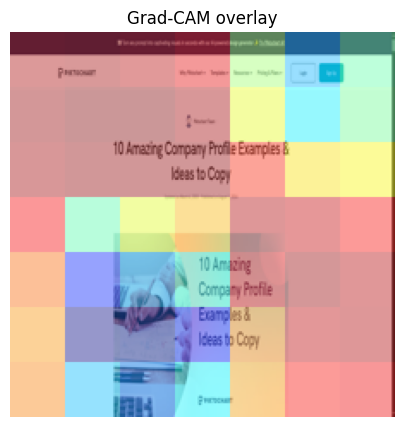

In [16]:
# find a conv2d layer in ResNet backbone
target_layer = None
for m in model.modules():
    if isinstance(m, torch.nn.Conv2d):
        target_layer = m
# more robust: take the last conv before avgpool: search for last Conv2d
conv_modules = [m for m in model.modules() if isinstance(m, torch.nn.Conv2d)]
target_layer = conv_modules[-1] if len(conv_modules)>0 else None

if target_layer is None:
    print("Could not find conv target for Grad-CAM.")
else:
    def forward_for_captum(img_tensor):
        # expects img_tensor (B,C,H,W) on DEVICE
        # NOTE: NO torch.no_grad() here - Grad-CAM needs gradients!
        # placeholders
        input_ids = torch.zeros(img_tensor.size(0), 8, dtype=torch.long).to(DEVICE)
        attn = torch.zeros(img_tensor.size(0), 8, dtype=torch.long).to(DEVICE)
        meta = torch.zeros(img_tensor.size(0), meta_dim).to(DEVICE)
        logits = model(input_ids=input_ids, attention_mask=attn, image=img_tensor, meta=meta)
        return logits

    gradcam = LayerGradCam(forward_for_captum, target_layer)
    # pick a val image
    sample_img = np.array(Image.open(val['image_path'].iloc[0]).convert("RGB").resize((IMG_INPUT_SIZE,IMG_INPUT_SIZE)))
    img_t = preprocess_image_np(sample_img).unsqueeze(0).to(DEVICE)
    attr = gradcam.attribute(img_t)  # No target needed for scalar output
    up = LayerAttribution.interpolate(attr, img_t.shape[2:]).squeeze().detach().cpu().numpy()
    upn = (up - up.min())/(up.max()-up.min()+1e-8)
    import cv2
    orig = (sample_img).astype(np.uint8)
    heatmap = cv2.applyColorMap(np.uint8(255*upn), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(cv2.cvtColor(orig, cv2.COLOR_RGB2BGR), 0.6, heatmap, 0.4, 0)
    plt.figure(figsize=(5,5))
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Grad-CAM overlay")


Text sample (short): Data Engineer

We're a data and design focused startup based in New York City with a passionate and forward-thinking team. We enable people to do what they love better, through data. This means we are building a groundbreaking data product and need your help achieving our goals.We’re a different kin


PartitionExplainer explainer: 2it [00:11, 11.58s/it]               
PartitionExplainer explainer: 2it [00:11, 11.58s/it]               


.values =
array([[-5.86869208e-04, -5.86869208e-04, -5.86869208e-04,
        -5.86869208e-04, -5.86869208e-04, -5.86869208e-04,
        -5.86869208e-04, -5.86869208e-04, -5.86869208e-04,
        -2.07396042e-03, -2.07396042e-03, -2.07396042e-03,
        -2.07396042e-03, -2.07396042e-03, -2.07396042e-03,
        -2.07396042e-03, -2.07396042e-03, -1.25380695e-03,
        -1.25380695e-03, -1.25380695e-03, -1.25380695e-03,
        -1.25380695e-03, -1.25380695e-03, -1.25380695e-03,
        -1.25380695e-03, -1.25380695e-03, -6.19005645e-04,
        -6.19005645e-04, -6.19005645e-04, -6.19005645e-04,
        -6.19005645e-04, -6.19005645e-04, -6.19005645e-04,
        -6.19005645e-04, -6.19005645e-04, -6.19005645e-04,
        -6.19005645e-04, -6.19005645e-04, -6.19005645e-04,
        -4.45610849e-04, -4.45610849e-04, -4.45610849e-04,
        -4.45610849e-04, -4.45610849e-04, -4.45610849e-04,
        -4.45610849e-04, -4.45610849e-04, -4.45610849e-04,
        -4.45610849e-04, -4.45610849e-04, -4.4

Token SHAP values: [-5.86869208e-04 -5.86869208e-04 -5.86869208e-04 -5.86869208e-04
 -5.86869208e-04 -5.86869208e-04 -5.86869208e-04 -5.86869208e-04
 -5.86869208e-04 -2.07396042e-03 -2.07396042e-03 -2.07396042e-03
 -2.07396042e-03 -2.07396042e-03 -2.07396042e-03 -2.07396042e-03
 -2.07396042e-03 -1.25380695e-03 -1.25380695e-03 -1.25380695e-03
 -1.25380695e-03 -1.25380695e-03 -1.25380695e-03 -1.25380695e-03
 -1.25380695e-03 -1.25380695e-03 -6.19005645e-04 -6.19005645e-04
 -6.19005645e-04 -6.19005645e-04 -6.19005645e-04 -6.19005645e-04
 -6.19005645e-04 -6.19005645e-04 -6.19005645e-04 -6.19005645e-04
 -6.19005645e-04 -6.19005645e-04 -6.19005645e-04 -4.45610849e-04
 -4.45610849e-04 -4.45610849e-04 -4.45610849e-04 -4.45610849e-04
 -4.45610849e-04 -4.45610849e-04 -4.45610849e-04 -4.45610849e-04
 -4.45610849e-04 -4.45610849e-04 -4.45610849e-04 -4.45610849e-04
 -4.45610849e-04 -4.45610849e-04 -4.45610849e-04 -4.45610849e-04
 -4.45610849e-04 -4.45610849e-04 -4.45610849e-04 -4.45610849e-04
 -4.45

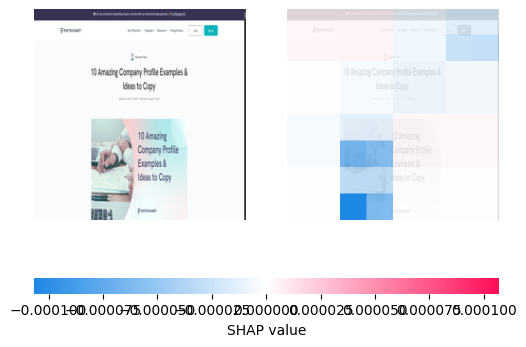

Meta SHAP explainer not available.


In [27]:
# TEXT SHAP (single sample)
sample_text = val['text'].iloc[0]
print("Text sample (short):", sample_text[:300])
sv_text = explainer_text([sample_text], max_evals=SHAP_TEXT_EVALS)
display(sv_text)
print("Token SHAP values:", sv_text[0].values)

# IMAGE SHAP (single sample)
sample_img_path = val['image_path'].iloc[0]
if sample_img_path and os.path.exists(sample_img_path):
    sample_img = np.array(Image.open(sample_img_path).convert("RGB").resize((IMG_INPUT_SIZE, IMG_INPUT_SIZE)))
    print("Image shape:", sample_img.shape)
    # SHAP image explainer expects numpy array
    sample_img_batch = np.array([sample_img])  # Add batch dimension
    sv_img = explainer_img(sample_img_batch, max_evals=SHAP_IMAGE_EVALS)
    shap.image_plot(sv_img.values, sample_img_batch)
else:
    print("Sample image not found")

# META SHAP (single sample)
if explainer_meta is not None:
    sample_meta = val_meta_np[0:1]
    sv_meta = explainer_meta.shap_values(sample_meta, nsamples=SHAP_META_NSAMPLES)
    shap.plots.bar(sv_meta, feature_names=meta_feature_names)
    print("Meta SHAP:", sv_meta)
else:
    print("Meta SHAP explainer not available.")


In [29]:
def modality_contribution_single(input_ids=None, attention_mask=None, image_tensor=None, meta_tensor=None):
    with torch.no_grad():
        base_logits = model(input_ids=input_ids, attention_mask=attention_mask, image=image_tensor, meta=meta_tensor)
        base_prob = float(torch.sigmoid(base_logits).detach().cpu().numpy().reshape(-1)[0])
    # text ablation
    if input_ids is not None:
        zero_ids = torch.zeros_like(input_ids).to(DEVICE)
        p_text = float(torch.sigmoid(model(input_ids=zero_ids, attention_mask=attention_mask, image=image_tensor, meta=meta_tensor).detach().cpu()).numpy().reshape(-1)[0])
    else:
        p_text = base_prob
    # image ablation
    if image_tensor is not None:
        zero_img = torch.zeros_like(image_tensor).to(DEVICE)
        p_img = float(torch.sigmoid(model(input_ids=input_ids, attention_mask=attention_mask, image=zero_img, meta=meta_tensor).detach().cpu()).numpy().reshape(-1)[0])
    else:
        p_img = base_prob
    # meta ablation
    if meta_tensor is not None:
        zero_meta = torch.zeros_like(meta_tensor).to(DEVICE)
        p_meta = float(torch.sigmoid(model(input_ids=input_ids, attention_mask=attention_mask, image=image_tensor, meta=zero_meta).detach().cpu()).numpy().reshape(-1)[0])
    else:
        p_meta = base_prob

    return {"base_prob": base_prob, "text_drop": base_prob - p_text, "image_drop": base_prob - p_img, "meta_drop": base_prob - p_meta}

def faithfulness_token_removal(input_ids, attention_mask, image_tensor, meta_tensor, token_importances, k=3):
    idxs = np.argsort(-np.abs(np.array(token_importances)))[:k]
    input_masked = input_ids.clone()
    pad = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else 0
    for j in idxs:
        input_masked[0,j] = pad
    with torch.no_grad():
        p_orig = float(torch.sigmoid(model(input_ids=input_ids, attention_mask=attention_mask, image=image_tensor, meta=meta_tensor)).detach().cpu().numpy().reshape(-1)[0])
        p_mask = float(torch.sigmoid(model(input_ids=input_masked, attention_mask=attention_mask, image=image_tensor, meta=meta_tensor)).detach().cpu().numpy().reshape(-1)[0])
    return {"orig": p_orig, "masked": p_mask, "drop": p_orig - p_mask}

# Example usage for first validation sample:
enc = tokenizer(val['text'].iloc[0], return_tensors="pt", truncation=True, padding=True)
input_ids = enc['input_ids'].to(DEVICE); attn = enc['attention_mask'].to(DEVICE)
img_np = np.array(Image.open(val['image_path'].iloc[0]).convert("RGB").resize((IMG_INPUT_SIZE,IMG_INPUT_SIZE)))
img_t = preprocess_image_np(img_np).unsqueeze(0).to(DEVICE)
meta_t = torch.tensor(val[meta_feature_names].iloc[0:1].astype(float).values, dtype=torch.float32).to(DEVICE)

contribs = modality_contribution_single(input_ids=input_ids, attention_mask=attn, image_tensor=img_t, meta_tensor=meta_t)
print("Modality contributions:", contribs)

# If IG token_importances from earlier exist, run faithfulness
if emb_layer is not None:
    token_importances = token_importances  # from Cell 12
    faith = faithfulness_token_removal(input_ids, attn, img_t, meta_t, token_importances, k=3)
    print("Faithfulness (token removal) result:", faith)


Modality contributions: {'base_prob': 0.00015547467046417296, 'text_drop': -0.030114133231109008, 'image_drop': -0.0018351062608417124, 'meta_drop': -2.0473773474805057e-05}
Faithfulness (token removal) result: {'orig': 0.00015547467046417296, 'masked': 0.0001611800689715892, 'drop': -5.705398507416248e-06}


Running XAI and saving outputs for 10 samples to xai_outputs


PartitionExplainer explainer: 2it [00:11, 11.65s/it]               
PartitionExplainer explainer: 2it [00:11, 11.65s/it]               


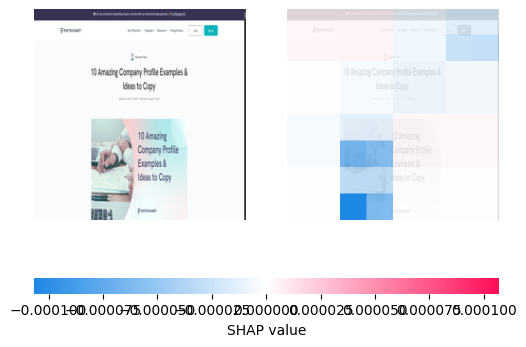

Saved sample 0


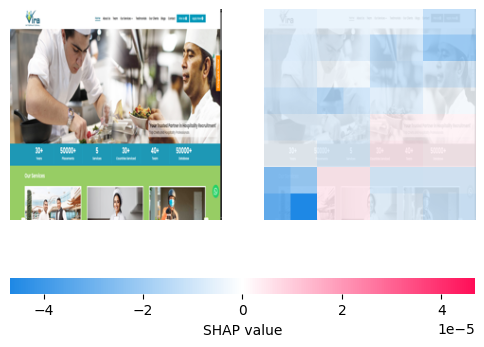

Saved sample 1


PartitionExplainer explainer: 2it [00:10, 10.50s/it]               
PartitionExplainer explainer: 2it [00:10, 10.50s/it]               


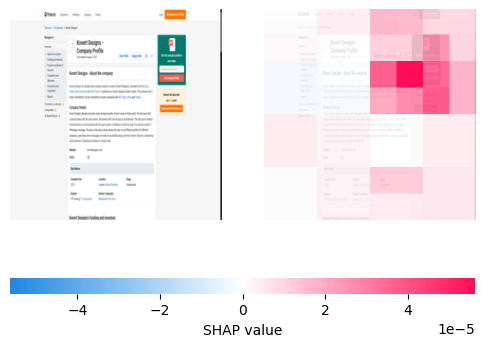

Saved sample 2


PartitionExplainer explainer: 2it [00:11, 11.78s/it]               
PartitionExplainer explainer: 2it [00:11, 11.78s/it]               


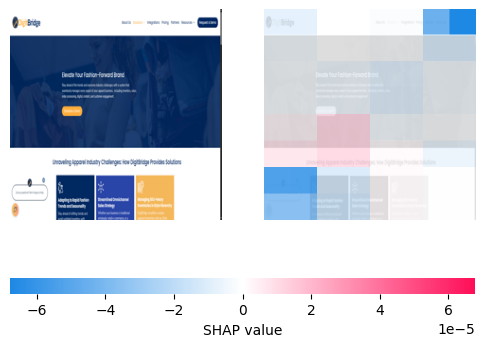

Saved sample 3


PartitionExplainer explainer: 2it [00:10, 10.88s/it]               
PartitionExplainer explainer: 2it [00:10, 10.88s/it]               


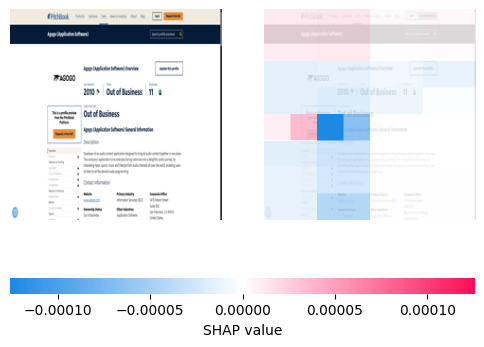

Saved sample 4


PartitionExplainer explainer: 2it [00:11, 11.43s/it]               
PartitionExplainer explainer: 2it [00:11, 11.43s/it]               


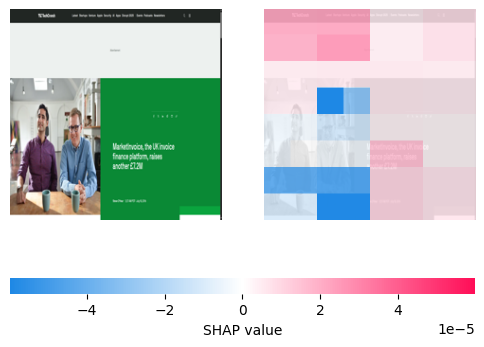

Saved sample 5


PartitionExplainer explainer: 2it [00:11, 11.49s/it]               
PartitionExplainer explainer: 2it [00:11, 11.49s/it]               


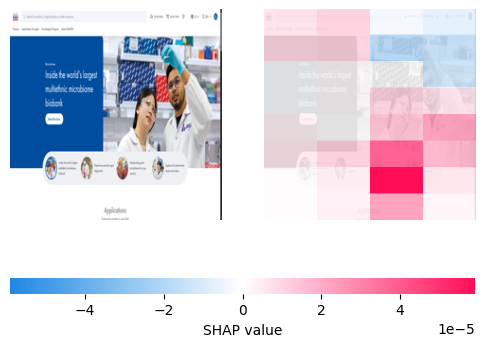

Saved sample 6


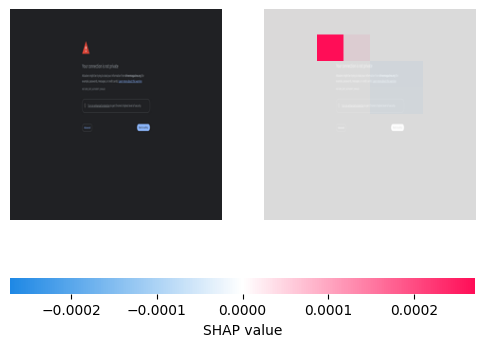

Saved sample 7


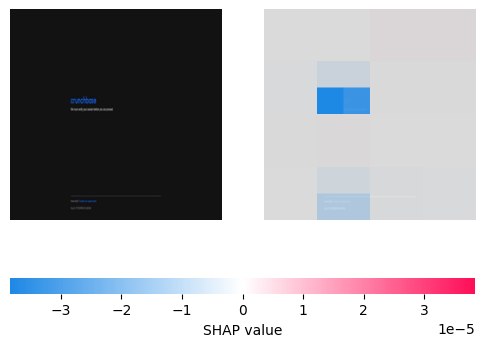

Saved sample 8


PartitionExplainer explainer: 2it [00:11, 11.81s/it]               
PartitionExplainer explainer: 2it [00:11, 11.81s/it]               


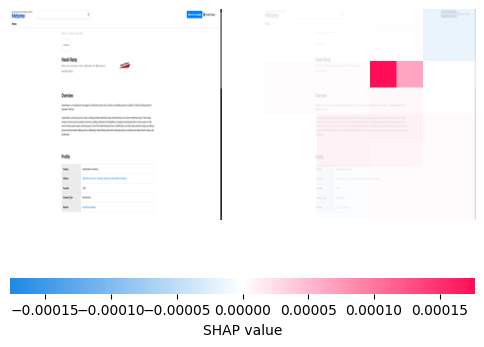

Saved sample 9
All done. Outputs -> xai_outputs


In [31]:
# Run on a small subset (N) and save PNGs + JSON metadata for each sample
N = min(10, len(val))
print("Running XAI and saving outputs for", N, "samples to", OUT_DIR)

for i in range(N):
    rec = {}
    row = val.iloc[i]
    txt = row['text']
    img_path = row['image_path']
    img_np = np.array(Image.open(img_path).convert("RGB").resize((IMG_INPUT_SIZE,IMG_INPUT_SIZE))) if img_path and os.path.exists(img_path) else np.ones((IMG_INPUT_SIZE,IMG_INPUT_SIZE,3), dtype=np.uint8)*255
    meta_arr = row[meta_feature_names].astype(float).values.reshape(1,-1)

    # Text SHAP
    try:
        svt = explainer_text([txt], max_evals=SHAP_TEXT_EVALS)
        plt.figure(figsize=(8,2))
        shap.plots.text(svt[0])
        plt.savefig(OUT_DIR / f"text_shap_{i}.png", bbox_inches='tight')
        plt.close()
        rec['text_shap_values'] = svt[0].values.tolist()
    except Exception as e:
        rec['text_shap_error'] = str(e)

    # Image SHAP
    try:
        img_batch = np.array([img_np])
        svi = explainer_img(img_batch, max_evals=SHAP_IMAGE_EVALS)
        shap.image_plot(svi.values, img_batch)
        plt.savefig(OUT_DIR / f"img_shap_{i}.png", bbox_inches='tight')
        plt.close()
        rec['image_shap_values'] = np.array(svi.values).tolist()
    except Exception as e:
        rec['image_shap_error'] = str(e)

    # Meta SHAP - skipped since explainer_meta is None
    rec['meta_shap_note'] = 'Meta SHAP explainer not available'

    # Grad-CAM
    try:
        if target_layer is not None:
            img_t = preprocess_image_np(img_np).unsqueeze(0).to(DEVICE)
            at = gradcam.attribute(img_t)
            up = LayerAttribution.interpolate(at, img_t.shape[2:]).squeeze().detach().cpu().numpy()
            upn = (up - up.min())/(up.max()-up.min()+1e-8)
            import cv2
            orig = (img_np).astype(np.uint8)
            heat = cv2.applyColorMap(np.uint8(255*upn), cv2.COLORMAP_JET)
            overlay = cv2.addWeighted(cv2.cvtColor(orig, cv2.COLOR_RGB2BGR), 0.6, heat, 0.4, 0)
            plt.figure(figsize=(5,5))
            plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.savefig(OUT_DIR / f"gradcam_{i}.png", bbox_inches='tight')
            plt.close()
            rec['gradcam_saved'] = True
    except Exception as e:
        rec['gradcam_error'] = str(e)

    # Modality ablation
    try:
        enc = tokenizer(txt, return_tensors="pt", truncation=True, padding=True)
        enc_ids = enc['input_ids'].to(DEVICE)
        enc_attn = enc['attention_mask'].to(DEVICE)
        img_t = preprocess_image_np(img_np).unsqueeze(0).to(DEVICE)
        meta_t = torch.tensor(meta_arr, dtype=torch.float32).to(DEVICE)
        rec['contribs'] = modality_contribution_single(input_ids=enc_ids, attention_mask=enc_attn, image_tensor=img_t, meta_tensor=meta_t)
    except Exception as e:
        rec['contribs_error'] = str(e)

    # Save JSON
    with open(OUT_DIR / f"xai_sample_{i}.json", "w", encoding="utf-8") as f:
        json.dump(rec, f, indent=2)
    print(f"Saved sample {i}")

print("All done. Outputs ->", OUT_DIR)
